# **Credit Risk Assessment**
## **Building an Application Scoring Model**


### **Dataset**
Data source:  
https://www.kaggle.com/competitions/GiveMeSomeCredit/data  


# Additional explanations for the task

In [3]:
# from google.colab import drive
import json
import zipfile

import pandas as pd

In [4]:
def load_dataset(from_kaggle:bool = False) -> pd.DataFrame:
  '''
  The function downloads data from the Kaggle website if from_kaggle=True is set.
  Otherwise, the archive is read from a local file (this method is convenient for those who don't have access to Kaggle).
  params:
      - from_kaggle - индикатор откуда скачивать данные (True - c сайта kaggle, False -  c локального файла)
  return:
      - pd.DataFrame

  '''
  if from_kaggle:
    # запросит разрешение к гугл диску, необходимо дать это разрешение
    drive.mount('/content/drive')
    # установим kaggle
    !pip install kaggle -q
    !mkdir ~/.kaggle
    # копируем kaggle.json (предварительно, необходимо сгенерить токен на
    # сайте kaggle и сохранить к себе на гугл диск) в папку ~/.kaggle/
    !cp "/content/drive/MyDrive/Colab Notebooks/config/kaggle.json" ~/.kaggle/
    !kaggle competitions download -c GiveMeSomeCredit
  else:
    !gdown 1MRYG6P6ScMTzTmXJlWdPdYQVNi04wLSm
  # распаковка архива
  zip_ref = zipfile.ZipFile('GiveMeSomeCredit.zip', 'r')
  zip_ref.extractall()
  zip_ref.close()
  df_train = pd.read_csv('cs-training.csv')
  df_test = pd.read_csv('cs-test.csv')
  return df_train, df_test

In [5]:
df_train, df_test = load_dataset(from_kaggle=False)

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
df_train

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


# 1.Exploratory Data Analysis

In [7]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Display data types and missing values
print("\n" + "=" * 80)
print("DATA TYPES AND MISSING VALUES")
print("=" * 80)
missing_info = pd.DataFrame({
    'Column': df_train.columns,
    'Data Type': df_train.dtypes,
    'Null Count': df_train.isnull().sum()
})
missing_info


DATA TYPES AND MISSING VALUES


,Column,Data Type,Null Count
Unnamed: 0,Unnamed: 0,int64,0
SeriousDlqin2yrs,SeriousDlqin2yrs,int64,0
RevolvingUtilizationOfUnsecuredLines,RevolvingUtilizationOfUnsecuredLines,float64,0
age,age,int64,0
NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse,int64,0
DebtRatio,DebtRatio,float64,0
MonthlyIncome,MonthlyIncome,float64,29731
NumberOfOpenCreditLinesAndLoans,NumberOfOpenCreditLinesAndLoans,int64,0
NumberOfTimes90DaysLate,NumberOfTimes90DaysLate,int64,0
NumberRealEstateLoansOrLines,NumberRealEstateLoansOrLines,int64,0


In [8]:
df_train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


TARGET VARIABLE DISTRIBUTION (SeriousDlqin2yrs)

Counts:
SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64

Percentages:
SeriousDlqin2yrs
0    93.316
1     6.684
Name: proportion, dtype: float64

Class imbalance ratio: 13.96:1

DISTRIBUTION OF NUMERICAL VARIABLES


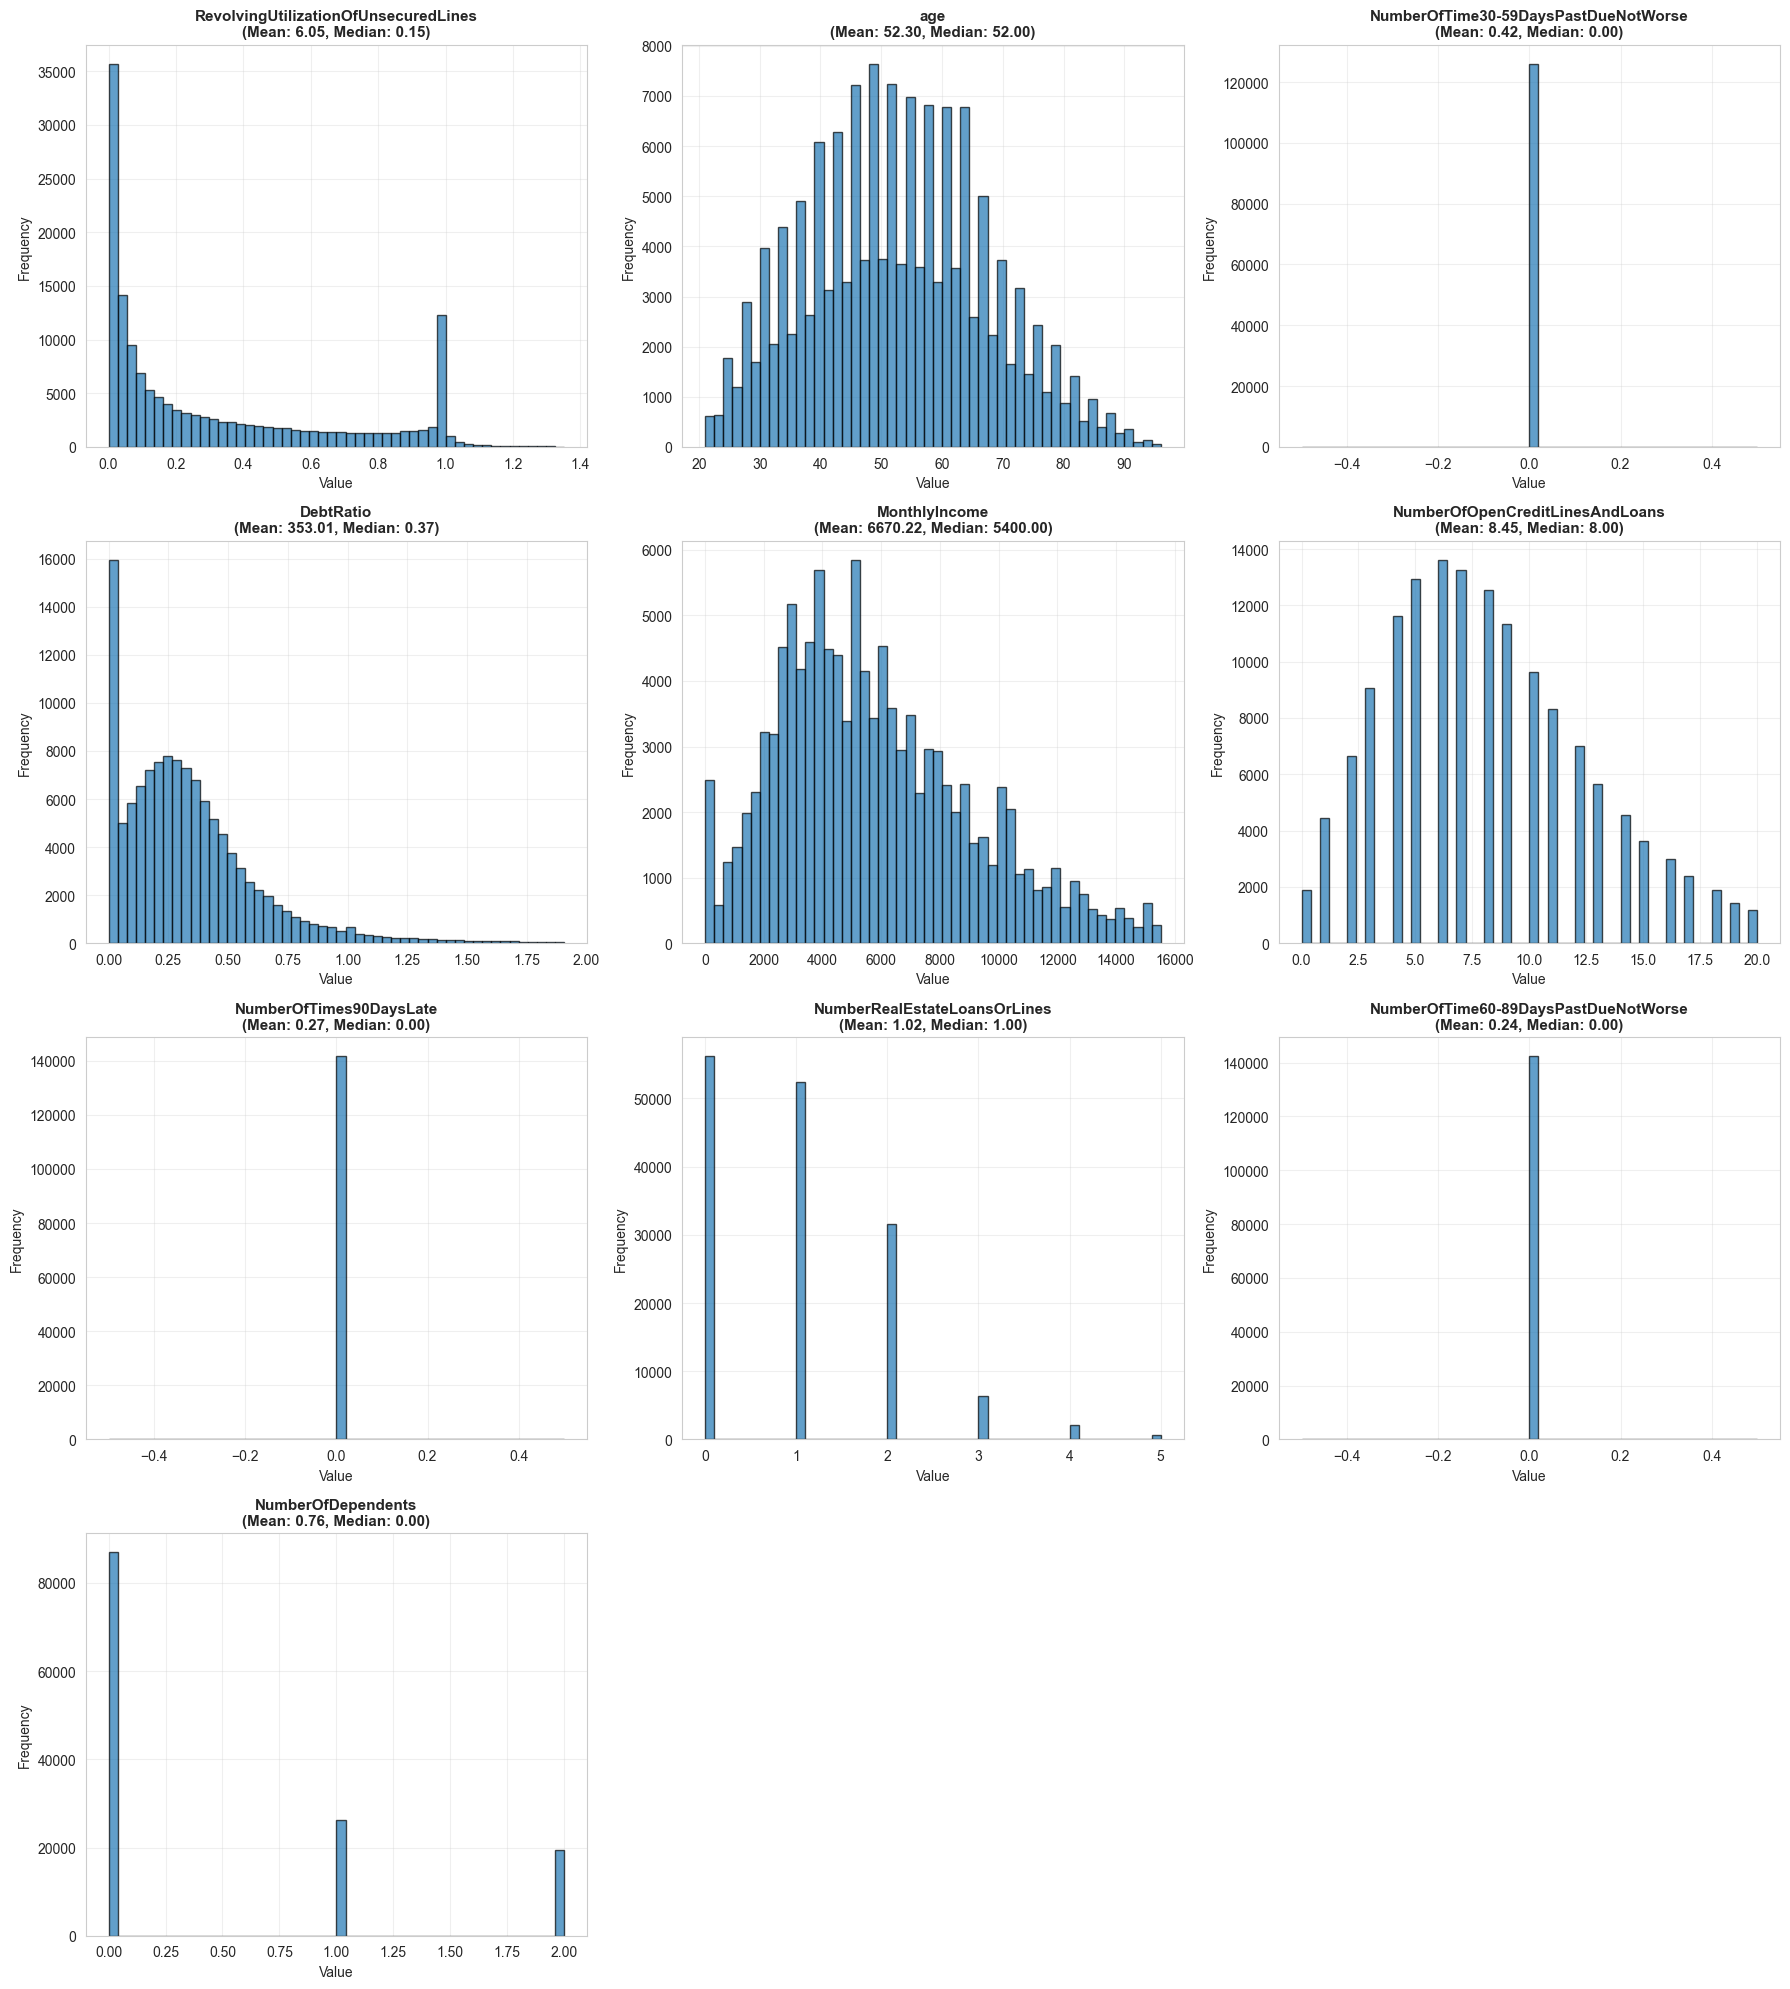


CORRELATION MATRIX
SeriousDlqin2yrs                        1.000000
NumberOfTime30-59DaysPastDueNotWorse    0.125587
NumberOfTimes90DaysLate                 0.117175
NumberOfTime60-89DaysPastDueNotWorse    0.102261
NumberOfDependents                      0.046048
RevolvingUtilizationOfUnsecuredLines   -0.001802
NumberRealEstateLoansOrLines           -0.007038
DebtRatio                              -0.007602
MonthlyIncome                          -0.019746
NumberOfOpenCreditLinesAndLoans        -0.029669
age                                    -0.115386
Name: SeriousDlqin2yrs, dtype: float64


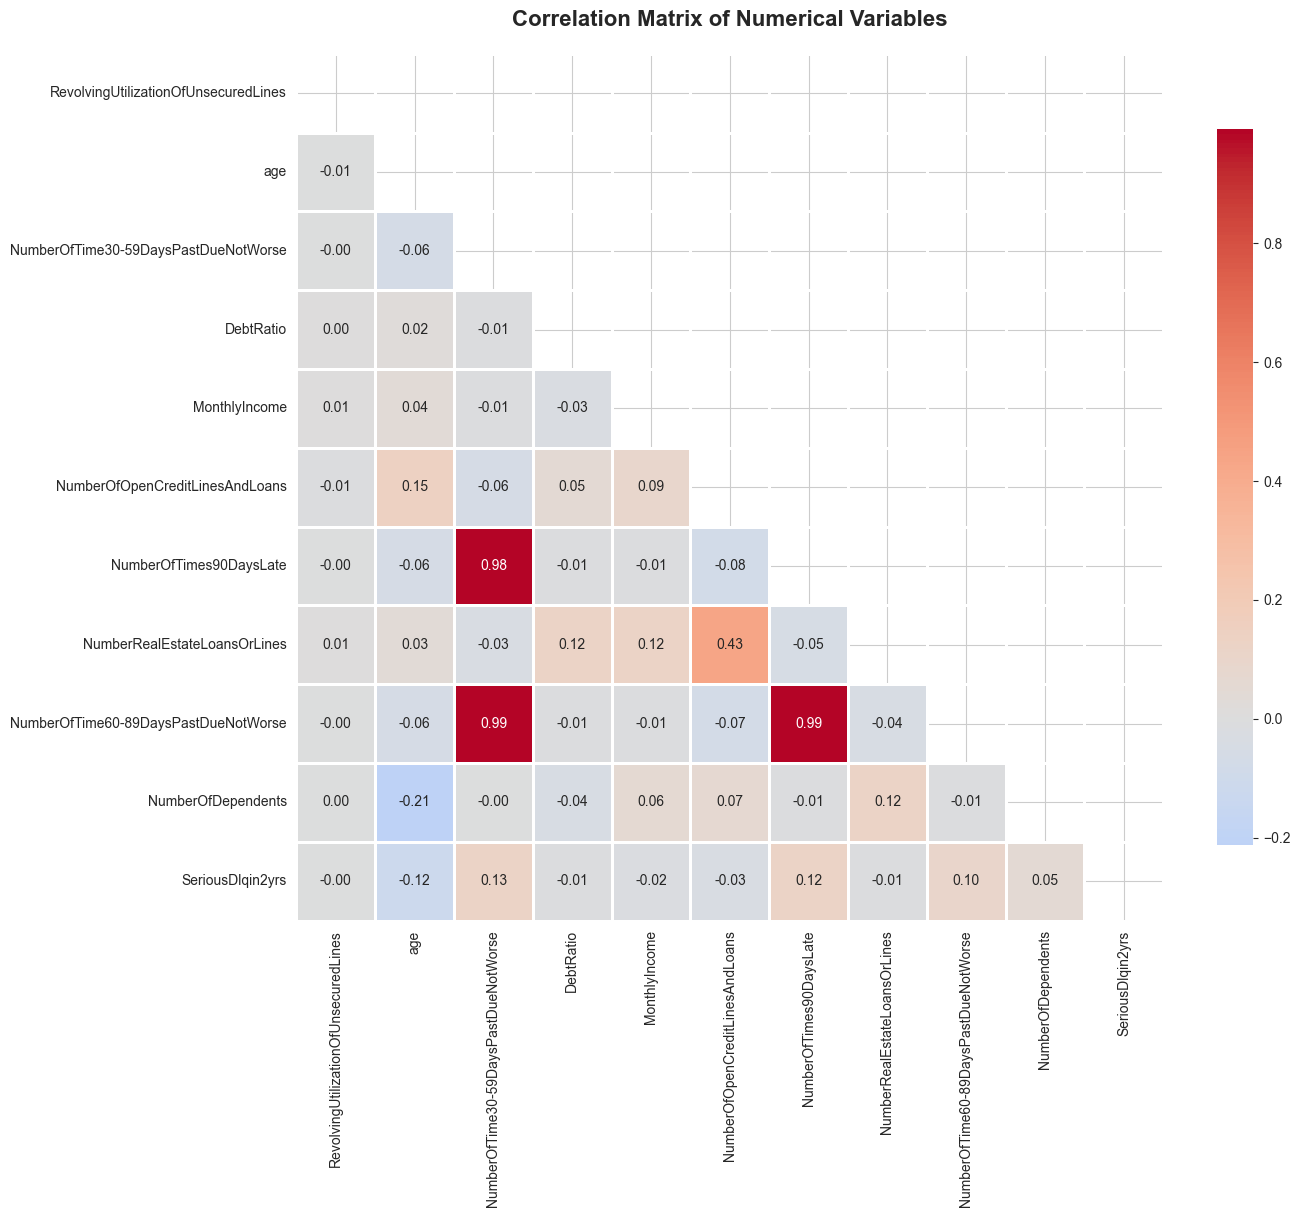

In [9]:
# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("TARGET VARIABLE DISTRIBUTION (SeriousDlqin2yrs)")
print("=" * 80)
target_dist = df_train['SeriousDlqin2yrs'].value_counts()
target_pct = df_train['SeriousDlqin2yrs'].value_counts(normalize=True) * 100
print(f"\nCounts:\n{target_dist}")
print(f"\nPercentages:\n{target_pct}")
print(f"\nClass imbalance ratio: {target_dist[0] / target_dist[1]:.2f}:1")

# Visualize target distribution
# target_pct.plot(kind='bar', ax=axes[1], color=['skyblue', 'salmon'])
# axes[1].set_title('Target Variable Distribution (Percentages)', fontsize=14, fontweight='bold')
# axes[1].set_xlabel('SeriousDlqin2yrs (0=No Default, 1=Default)', fontsize=12)
# axes[1].set_ylabel('Percentage (%)', fontsize=12)
# axes[1].set_xticklabels(['No Default', 'Default'], rotation=0)
# for i, v in enumerate(target_pct):
#     axes[1].text(i, v + 0.5, f'{v:.2f}%', ha='center', fontweight='bold')
# plt.tight_layout()
# plt.show()

# Distribution of numerical variables
numerical_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('SeriousDlqin2yrs')  # Remove target variable
numerical_cols.remove('Unnamed: 0')  # Remove index column

print("\n" + "=" * 80)
print("DISTRIBUTION OF NUMERICAL VARIABLES")
print("=" * 80)

# Create histograms for numerical variables
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    # Remove outliers for better visualization (using IQR method)
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data_clean = df_train[(df_train[col] >= lower_bound) & (df_train[col] <= upper_bound)][col]

    axes[idx].hist(data_clean, bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col}\n(Mean: {df_train[col].mean():.2f}, Median: {df_train[col].median():.2f})',
                        fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Value', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(numerical_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Correlation matrix
print("\n" + "=" * 80)
print("CORRELATION MATRIX")
print("=" * 80)
corr_matrix = df_train[numerical_cols + ['SeriousDlqin2yrs']].corr()
print(corr_matrix['SeriousDlqin2yrs'].sort_values(ascending=False))

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Conclusions from Exploratory Data Analysis

Based on the exploratory data analysis, the following key findings can be summarized:

### 1. **Dataset Overview**
- There are 150 000 values
- All numerical
- Missing values are present in MonthlyIncome and NumberOfDependent, but the account for less than 20% of all values

### 2. **Target Variable Distribution**
6,684% - zeros, other - ones

### 3. **Data Quality Issues**
Missing values in MonthlyIncome and NumberOfDependents need to be imputed or deleted

### 4. **Business Implications**
Past payment behavior is appears to be the most important predictor of future financial distress



# 2.Creating additional variables 


In [10]:
df_train_features = df_train.copy()
df_test_features = df_test.copy()

# 1. Total Past Due Events - Sum of all past due occurrences
# This captures overall payment delinquency history
df_train_features['TotalPastDue'] = (
    df_train_features['NumberOfTime30-59DaysPastDueNotWorse'] +
    df_train_features['NumberOfTime60-89DaysPastDueNotWorse'] +
    df_train_features['NumberOfTimes90DaysLate']
)
df_test_features['TotalPastDue'] = (
    df_test_features['NumberOfTime30-59DaysPastDueNotWorse'] +
    df_test_features['NumberOfTime60-89DaysPastDueNotWorse'] +
    df_test_features['NumberOfTimes90DaysLate']
)

# 2. Credit Utilization to Income Ratio
# Higher utilization relative to income may indicate financial stress
# Handle missing MonthlyIncome by using median
median_income_train = df_train_features['MonthlyIncome'].median()
median_income_test = df_test_features['MonthlyIncome'].median()

df_train_features['MonthlyIncome_filled'] = df_train_features['MonthlyIncome'].fillna(median_income_train)
df_test_features['MonthlyIncome_filled'] = df_test_features['MonthlyIncome'].fillna(median_income_test)

# Create ratio
df_train_features['UtilizationToIncomeRatio'] = np.where(
    df_train_features['MonthlyIncome_filled'] > 0,
    df_train_features['RevolvingUtilizationOfUnsecuredLines'] / (df_train_features['MonthlyIncome_filled'] + 1),
    df_train_features['RevolvingUtilizationOfUnsecuredLines']
)
df_test_features['UtilizationToIncomeRatio'] = np.where(
    df_test_features['MonthlyIncome_filled'] > 0,
    df_test_features['RevolvingUtilizationOfUnsecuredLines'] / (df_test_features['MonthlyIncome_filled'] + 1),
    df_test_features['RevolvingUtilizationOfUnsecuredLines']
)

# 3. Debt Service Ratio (DebtRatio adjusted for income)
# This provides a more interpretable measure of debt burden
df_train_features['DebtServiceRatio'] = df_train_features['DebtRatio'] * df_train_features['MonthlyIncome_filled']
df_test_features['DebtServiceRatio'] = df_test_features['DebtRatio'] * df_test_features['MonthlyIncome_filled']

# 4. Credit Lines Utilization Rate
# Ratio of open credit lines to total credit capacity indicator
df_train_features['CreditLinesUtilization'] = np.where(
    df_train_features['NumberOfOpenCreditLinesAndLoans'] > 0,
    df_train_features['RevolvingUtilizationOfUnsecuredLines'] / df_train_features['NumberOfOpenCreditLinesAndLoans'],
    df_train_features['RevolvingUtilizationOfUnsecuredLines']
)
df_test_features['CreditLinesUtilization'] = np.where(
    df_test_features['NumberOfOpenCreditLinesAndLoans'] > 0,
    df_test_features['RevolvingUtilizationOfUnsecuredLines'] / df_test_features['NumberOfOpenCreditLinesAndLoans'],
    df_test_features['RevolvingUtilizationOfUnsecuredLines']
)

# 5. High Risk Past Due Indicator
# Binary indicator for customers with severe past due history (90+ days)
df_train_features['HighRiskPastDue'] = (df_train_features['NumberOfTimes90DaysLate'] > 0).astype(int)
df_test_features['HighRiskPastDue'] = (df_test_features['NumberOfTimes90DaysLate'] > 0).astype(int)

# 6. Real Estate to Total Credit Ratio
# Proportion of real estate loans in total credit portfolio
df_train_features['RealEstateRatio'] = np.where(
    df_train_features['NumberOfOpenCreditLinesAndLoans'] > 0,
    df_train_features['NumberRealEstateLoansOrLines'] / df_train_features['NumberOfOpenCreditLinesAndLoans'],
    0
)
df_test_features['RealEstateRatio'] = np.where(
    df_test_features['NumberOfOpenCreditLinesAndLoans'] > 0,
    df_test_features['NumberRealEstateLoansOrLines'] / df_test_features['NumberOfOpenCreditLinesAndLoans'],
    0
)

# 7. Dependents Adjusted Income
# Income per dependent, which may indicate financial capacity
median_dependents_train = df_train_features['NumberOfDependents'].median()
median_dependents_test = df_test_features['NumberOfDependents'].median()

df_train_features['NumberOfDependents_filled'] = df_train_features['NumberOfDependents'].fillna(median_dependents_train)
df_test_features['NumberOfDependents_filled'] = df_test_features['NumberOfDependents'].fillna(median_dependents_test)

df_train_features['IncomePerDependent'] = np.where(
    df_train_features['NumberOfDependents_filled'] > 0,
    df_train_features['MonthlyIncome_filled'] / (df_train_features['NumberOfDependents_filled'] + 1),
    df_train_features['MonthlyIncome_filled']
)
df_test_features['IncomePerDependent'] = np.where(
    df_test_features['NumberOfDependents_filled'] > 0,
    df_test_features['MonthlyIncome_filled'] / (df_test_features['NumberOfDependents_filled'] + 1),
    df_test_features['MonthlyIncome_filled']
)



CORRELATION MATRIX
SeriousDlqin2yrs                        1.000000
HighRiskPastDue                         0.339577
NumberOfTime30-59DaysPastDueNotWorse    0.125587
NumberOfTimes90DaysLate                 0.117175
TotalPastDue                            0.115513
NumberOfTime60-89DaysPastDueNotWorse    0.102261
NumberOfDependents_filled               0.046869
NumberOfDependents                      0.046048
Unnamed: 0                              0.002801
UtilizationToIncomeRatio               -0.000745
RevolvingUtilizationOfUnsecuredLines   -0.001802
CreditLinesUtilization                 -0.002381
NumberRealEstateLoansOrLines           -0.007038
DebtServiceRatio                       -0.007260
DebtRatio                              -0.007602
RealEstateRatio                        -0.010098
MonthlyIncome_filled                   -0.017151
MonthlyIncome                          -0.019746
IncomePerDependent                     -0.026626
NumberOfOpenCreditLinesAndLoans        -0.029669


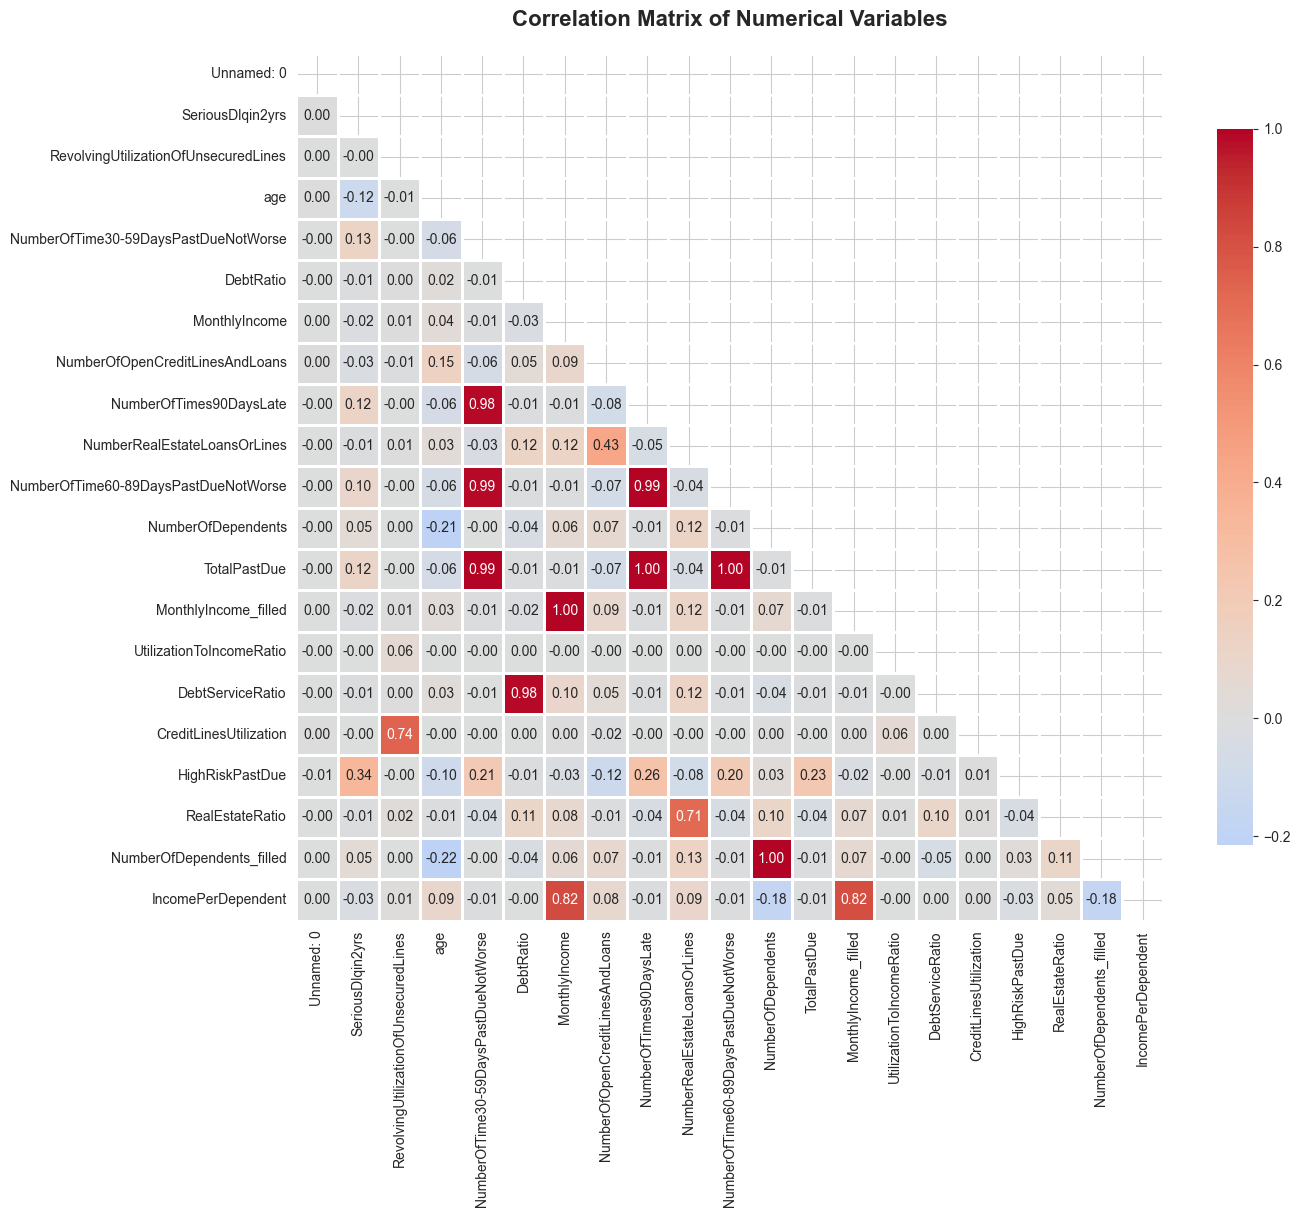

In [11]:
# Correlation matrix
print("\n" + "=" * 80)
print("CORRELATION MATRIX")
print("=" * 80)
corr_matrix = df_train_features.corr()
print(corr_matrix['SeriousDlqin2yrs'].sort_values(ascending=False))

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# 3. Model building 

In [ ]:
from sklearn.model_selection import train_test_split

# Prepare features and target
# Select original variables + new variables for modeling
feature_cols = [
    'RevolvingUtilizationOfUnsecuredLines', 'age',
    'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
    'MonthlyIncome_filled', 'NumberOfOpenCreditLinesAndLoans',
    'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
    'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents_filled',
    'TotalPastDue', 'UtilizationToIncomeRatio', 'DebtServiceRatio',
    'CreditLinesUtilization', 'HighRiskPastDue', 'RealEstateRatio', 'IncomePerDependent'
]

X = df_train_features[feature_cols].copy()
y = df_train_features['SeriousDlqin2yrs'].copy()

# Split into train and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



STEP 1: FINE CLASSIFICATION (20 bins per feature)
RevolvingUtilizationOfUnsecuredLines - IV: 1.1613, Bins: 19
age                                 - IV: 0.2501, Bins: 20
DebtRatio                           - IV: 0.0790, Bins: 20
MonthlyIncome_filled                - IV: 0.0776, Bins: 17
NumberOfOpenCreditLinesAndLoans     - IV: 0.0880, Bins: 15
NumberRealEstateLoansOrLines        - IV: 0.0192, Bins: 4
NumberOfDependents_filled           - IV: 0.0247, Bins: 4
TotalPastDue                        - IV: 1.1022, Bins: 3
UtilizationToIncomeRatio            - IV: 0.9762, Bins: 19
DebtServiceRatio                    - IV: 0.0352, Bins: 20
CreditLinesUtilization              - IV: 0.8960, Bins: 19
RealEstateRatio                     - IV: 0.0585, Bins: 13
IncomePerDependent                  - IV: 0.0982, Bins: 18

INFORMATION VALUE (IV) SCORES
                             Feature       IV
RevolvingUtilizationOfUnsecuredLines 1.161300
                        TotalPastDue 1.102215
            Util

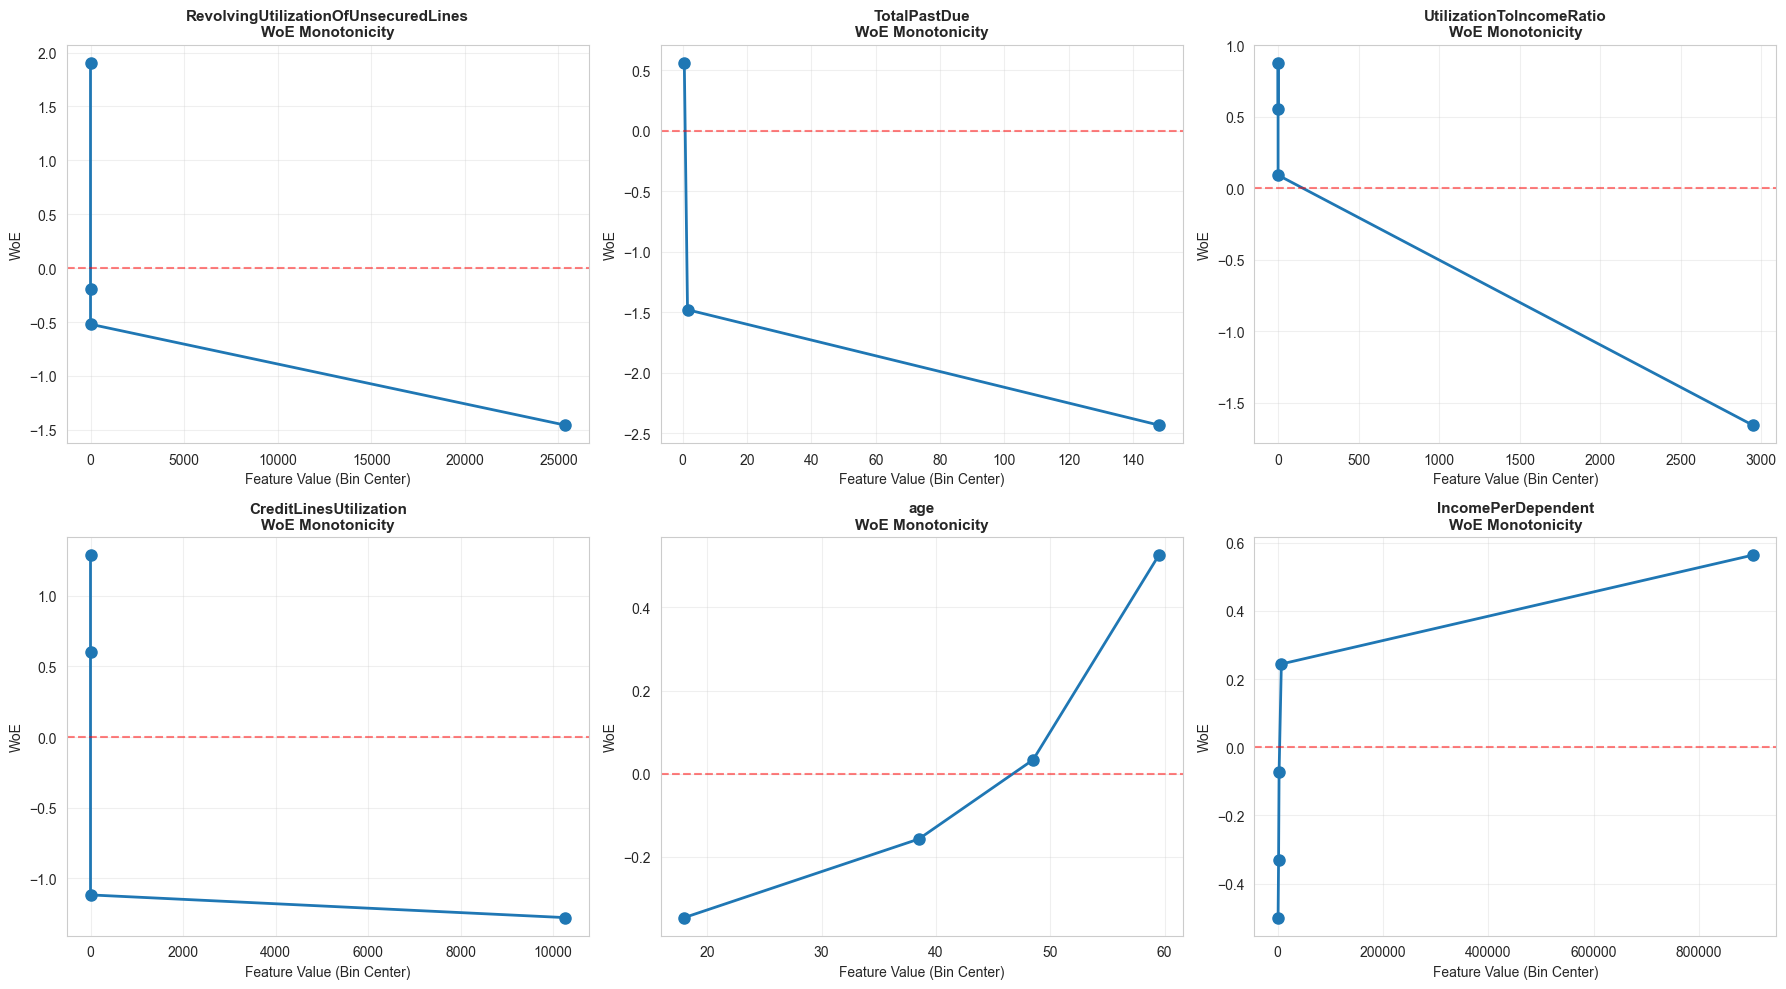


APPLYING WoE TRANSFORMATION TO DATA
✓ RevolvingUtilizationOfUnsecuredLines
✓ age
✓ DebtRatio
✓ MonthlyIncome_filled
✓ NumberOfOpenCreditLinesAndLoans
✓ NumberRealEstateLoansOrLines
✓ NumberOfDependents_filled
✓ TotalPastDue
✓ UtilizationToIncomeRatio
✓ DebtServiceRatio
✓ CreditLinesUtilization
✓ RealEstateRatio
✓ IncomePerDependent

Final feature set: 17 features
Features: ['RevolvingUtilizationOfUnsecuredLines_WoE', 'age_WoE', 'DebtRatio_WoE', 'MonthlyIncome_filled_WoE', 'NumberOfOpenCreditLinesAndLoans_WoE', 'NumberRealEstateLoansOrLines_WoE', 'NumberOfDependents_filled_WoE', 'TotalPastDue_WoE', 'UtilizationToIncomeRatio_WoE', 'DebtServiceRatio_WoE', 'CreditLinesUtilization_WoE', 'RealEstateRatio_WoE', 'IncomePerDependent_WoE', 'HighRiskPastDue', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']


In [14]:
# WoE (Weight of Evidence) Transformation
# Step 1: Fine Classification - Split into many bins
# Step 2: Coarse Classification - Combine bins to ensure monotonicity

def calculate_woe_iv(X_data, y_data, feature, n_bins=20):
    """
    Calculate WoE and IV for a feature
    Returns: grouped DataFrame with bin statistics, WoE dictionary, and IV score
    """
    # Create a copy and handle missing values
    data = pd.DataFrame({feature: X_data[feature].fillna(X_data[feature].median()),
                         'target': y_data})

    # Create bins using quantiles (fine classification)
    try:
        data['bin'] = pd.qcut(data[feature], q=n_bins, duplicates='drop')
    except:
        # If quantile cut fails, use equal-width bins
        data['bin'] = pd.cut(data[feature], bins=n_bins, duplicates='drop')

    # Calculate statistics for each bin
    grouped = data.groupby('bin', observed=True).agg({
        'target': ['count', 'sum', 'mean']
    })
    grouped.columns = ['Total', 'Bad', 'Bad_Rate']
    grouped['Good'] = grouped['Total'] - grouped['Bad']

    # Calculate percentages
    total_good = grouped['Good'].sum()
    total_bad = grouped['Bad'].sum()

    if total_good == 0 or total_bad == 0:
        return None, None, None

    grouped['Good_Pct'] = grouped['Good'] / total_good
    grouped['Bad_Pct'] = grouped['Bad'] / total_bad

    # Calculate WoE: log(Good_Pct / Bad_Pct)
    grouped['WoE'] = np.log((grouped['Good_Pct'] + 1e-6) / (grouped['Bad_Pct'] + 1e-6))

    # Calculate IV (Information Value)
    grouped['IV'] = (grouped['Good_Pct'] - grouped['Bad_Pct']) * grouped['WoE']
    iv_total = grouped['IV'].sum()

    # Extract bin boundaries
    grouped['Bin_Min'] = grouped.index.map(lambda x: x.left if hasattr(x, 'left') else float('-inf'))
    grouped['Bin_Max'] = grouped.index.map(lambda x: x.right if hasattr(x, 'right') else float('inf'))

    return grouped, grouped['WoE'].to_dict(), iv_total

def coarse_classification(grouped, max_bins=5):
    """
    Combine bins to ensure monotonic WoE (coarse classification)
    Groups adjacent bins with similar WoE values
    """
    grouped_sorted = grouped.sort_values('Bin_Min').copy()
    woe_values = grouped_sorted['WoE'].values

    # Group bins with similar WoE values
    bins_list = []
    current_group = [0]

    for i in range(1, len(woe_values)):
        # Combine if WoE difference is small (< 0.1)
        if abs(woe_values[i] - woe_values[current_group[-1]]) < 0.1:
            current_group.append(i)
        else:
            bins_list.append(current_group)
            current_group = [i]
    bins_list.append(current_group)

    # Reduce to max_bins by merging smallest groups
    while len(bins_list) > max_bins:
        sizes = [len(b) for b in bins_list]
        min_idx = sizes.index(min(sizes))

        # Merge with neighbor
        if min_idx == 0:
            bins_list[0] = bins_list[0] + bins_list[1]
            bins_list.pop(1)
        elif min_idx == len(bins_list) - 1:
            bins_list[-2] = bins_list[-2] + bins_list[-1]
            bins_list.pop(-1)
        else:
            # Merge with closer neighbor (by WoE similarity)
            left_woe = grouped_sorted.iloc[bins_list[min_idx-1][-1]]['WoE']
            right_woe = grouped_sorted.iloc[bins_list[min_idx+1][0]]['WoE']
            current_woe = grouped_sorted.iloc[bins_list[min_idx][0]]['WoE']

            if abs(current_woe - left_woe) < abs(current_woe - right_woe):
                bins_list[min_idx-1] = bins_list[min_idx-1] + bins_list[min_idx]
            else:
                bins_list[min_idx] = bins_list[min_idx] + bins_list[min_idx+1]
                bins_list.pop(min_idx+1)
            bins_list.pop(min_idx)

    # Create new grouped dataframe
    coarse_groups = []
    for bin_group in bins_list:
        group_data = grouped_sorted.iloc[bin_group]
        coarse_groups.append({
            'Total': group_data['Total'].sum(),
            'Bad': group_data['Bad'].sum(),
            'Good': group_data['Good'].sum(),
            'Bad_Rate': group_data['Bad'].sum() / group_data['Total'].sum() if group_data['Total'].sum() > 0 else 0,
            'Bin_Min': group_data['Bin_Min'].min(),
            'Bin_Max': group_data['Bin_Max'].max()
        })

    coarse_df = pd.DataFrame(coarse_groups)
    total_good = coarse_df['Good'].sum()
    total_bad = coarse_df['Bad'].sum()

    # Recalculate WoE for combined bins
    coarse_df['Good_Pct'] = coarse_df['Good'] / total_good
    coarse_df['Bad_Pct'] = coarse_df['Bad'] / total_bad
    coarse_df['WoE'] = np.log((coarse_df['Good_Pct'] + 1e-6) / (coarse_df['Bad_Pct'] + 1e-6))
    coarse_df['IV'] = (coarse_df['Good_Pct'] - coarse_df['Bad_Pct']) * coarse_df['WoE']

    return coarse_df

# Step 1: Fine Classification
print("=" * 80)
print("STEP 1: FINE CLASSIFICATION (20 bins per feature)")
print("=" * 80)

# Select numerical features for WoE transformation
woe_features = [
    'RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
    'MonthlyIncome_filled', 'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines', 'NumberOfDependents_filled',
    'TotalPastDue', 'UtilizationToIncomeRatio', 'DebtServiceRatio',
    'CreditLinesUtilization', 'RealEstateRatio', 'IncomePerDependent'
]

fine_classification_results = {}
iv_scores = {}

for feature in woe_features:
    if feature in X_train.columns:
        grouped, woe_map, iv = calculate_woe_iv(X_train, y_train, feature, n_bins=20)
        if grouped is not None:
            fine_classification_results[feature] = grouped
            iv_scores[feature] = iv
            print(f"{feature:35s} - IV: {iv:.4f}, Bins: {len(grouped)}")

# Display IV scores
print("\n" + "=" * 80)
print("INFORMATION VALUE (IV) SCORES")
print("=" * 80)
iv_df = pd.DataFrame(list(iv_scores.items()), columns=['Feature', 'IV'])
iv_df = iv_df.sort_values('IV', ascending=False)
print(iv_df.to_string(index=False))

# Step 2: Coarse Classification
print("\n" + "=" * 80)
print("STEP 2: COARSE CLASSIFICATION (max 5 bins per feature)")
print("=" * 80)

coarse_classification_results = {}

for feature in woe_features:
    if feature in fine_classification_results:
        coarse_df = coarse_classification(fine_classification_results[feature], max_bins=5)
        coarse_classification_results[feature] = coarse_df
        print(f"\n{feature}: {len(coarse_df)} bins")
        print(coarse_df[['Bin_Min', 'Bin_Max', 'Total', 'Bad', 'Bad_Rate', 'WoE']].round(4))

# Visualize WoE monotonicity
print("\n" + "=" * 80)
print("VISUALIZING WoE MONOTONICITY")
print("=" * 80)

top_features = iv_df.head(6)['Feature'].tolist()
n_plots = min(len(top_features), 6)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
if n_plots == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, feature in enumerate(top_features[:n_plots]):
    if feature in coarse_classification_results:
        coarse_df = coarse_classification_results[feature]
        bin_centers = (coarse_df['Bin_Min'] + coarse_df['Bin_Max']) / 2

        axes[idx].plot(bin_centers, coarse_df['WoE'], marker='o', linewidth=2, markersize=8)
        axes[idx].set_title(f'{feature}\nWoE Monotonicity', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Feature Value (Bin Center)', fontsize=10)
        axes[idx].set_ylabel('WoE', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Hide unused subplots
for idx in range(n_plots, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Apply WoE transformation
print("\n" + "=" * 80)
print("APPLYING WoE TRANSFORMATION TO DATA")
print("=" * 80)

def apply_woe_transformation(X_data, feature, coarse_df):
    """Apply WoE transformation to a feature using coarse classification bins"""
    feature_values = X_data[feature].fillna(X_data[feature].median())

    # Create bins based on coarse classification boundaries
    bins = [-np.inf] + coarse_df['Bin_Max'].tolist()[:-1] + [np.inf]
    labels = range(len(coarse_df))

    binned = pd.cut(feature_values, bins=bins, labels=labels, include_lowest=True)

    # Map to WoE values
    woe_mapping = dict(zip(labels, coarse_df['WoE'].values))
    woe_values = binned.map(woe_mapping)

    return woe_values

# Apply WoE to training and validation sets
X_train_woe = X_train.copy()
X_val_woe = X_val.copy()

for feature in woe_features:
    if feature in coarse_classification_results:
        X_train_woe[f'{feature}_WoE'] = apply_woe_transformation(
            X_train, feature, coarse_classification_results[feature]
        )
        X_val_woe[f'{feature}_WoE'] = apply_woe_transformation(
            X_val, feature, coarse_classification_results[feature]
        )
        print(f"✓ {feature}")

# Prepare final feature sets for modeling
woe_feature_cols = [f'{f}_WoE' for f in woe_features if f in coarse_classification_results]
binary_features = ['HighRiskPastDue', 'NumberOfTime30-59DaysPastDueNotWorse',
                   'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']

# Select only features that exist in the data
available_binary = [f for f in binary_features if f in X_train_woe.columns]

X_train_final = X_train_woe[woe_feature_cols + available_binary].copy()
X_val_final = X_val_woe[woe_feature_cols + available_binary].copy()

print(f"\nFinal feature set: {len(X_train_final.columns)} features")
print(f"Features: {X_train_final.columns.tolist()}")

### Constructing and evaluating logistic regression 

LOGISTIC REGRESSION MODEL
✓ Model trained with 17 features

MODEL EVALUATION

ROC AUC Score:
  Training: 0.8367
  Validation: 0.8404

F1 Score:
  Training: 0.2995
  Validation: 0.2846

Precision:
  Training: 0.5490
  Validation: 0.5374

Recall:
  Training: 0.2060
  Validation: 0.1935

Confusion Matrix (Validation):
[[27661   334]
 [ 1617   388]]

True Negatives: 27661, False Positives: 334
False Negatives: 1617, True Positives: 388

Classification Report (Validation):
              precision    recall  f1-score   support

  No Default       0.94      0.99      0.97     27995
     Default       0.54      0.19      0.28      2005

    accuracy                           0.93     30000
   macro avg       0.74      0.59      0.63     30000
weighted avg       0.92      0.93      0.92     30000



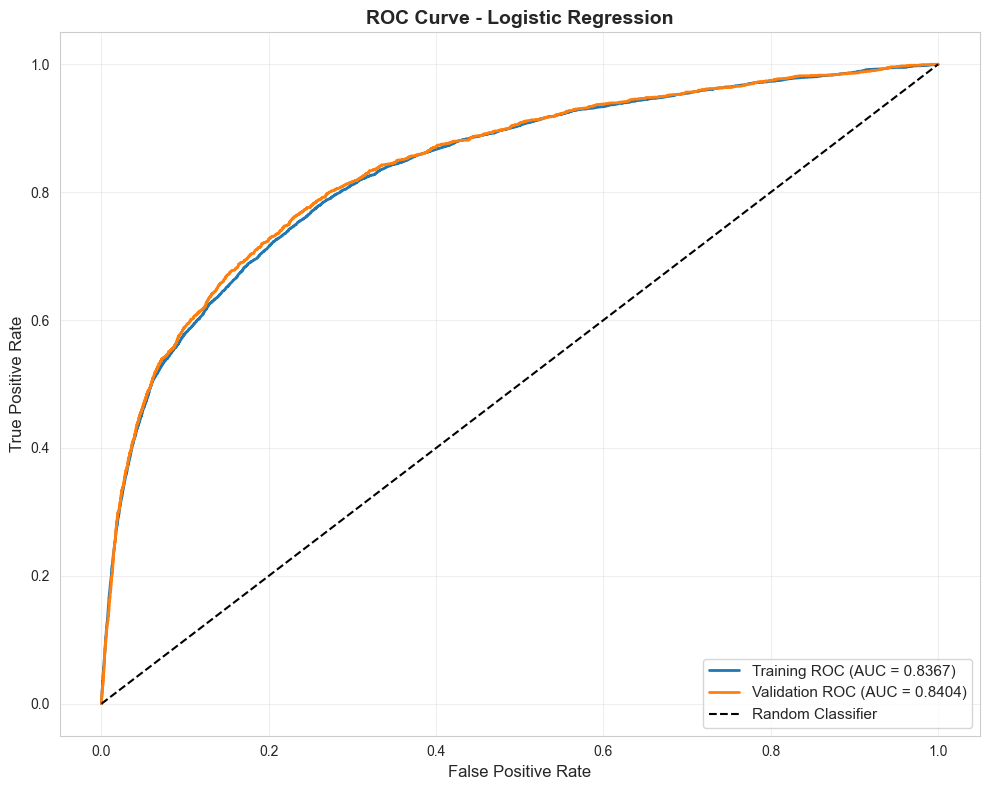


SCORECARD CONSTRUCTION
Scorecard Parameters:
  PDO (Points to Double Odds): 20
  Target Score: 600
  Target Odds: 50:1
  Factor: 28.8539
  Offset: 487.1229

Model Intercept (α): -3.2299
Number of features (n): 17

Scorecard (Points per feature):
                                 Feature  Coefficient    Points
                         HighRiskPastDue     1.303189 66.256362
                    DebtServiceRatio_WoE     0.147816 32.919367
                  IncomePerDependent_WoE     0.087757 31.186428
    NumberOfTime60-89DaysPastDueNotWorse     0.086289 31.144050
    NumberOfTime30-59DaysPastDueNotWorse     0.059876 30.381932
                MonthlyIncome_filled_WoE    -0.076213 26.455248
              CreditLinesUtilization_WoE    -0.144985 24.470915
                 NumberOfTimes90DaysLate    -0.149707 24.334654
     NumberOfOpenCreditLinesAndLoans_WoE    -0.178440 23.505583
RevolvingUtilizationOfUnsecuredLines_WoE    -0.294053 20.169702
                     RealEstateRatio_WoE    -0.32

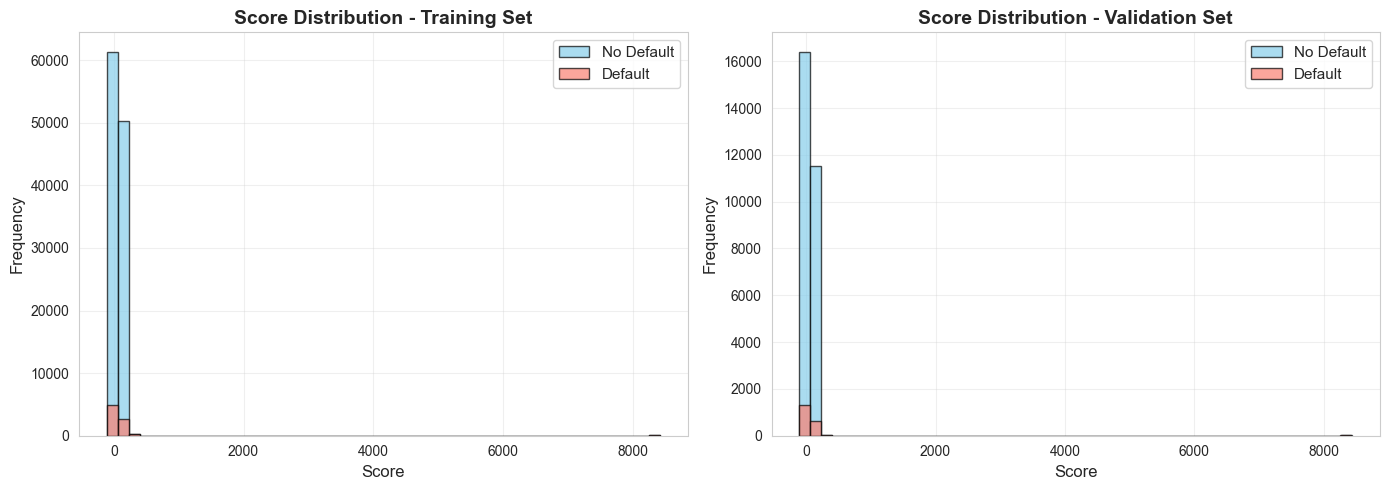


Score Statistics:
  Training - Mean: 60.93, Std: 357.28
  Training - Min: -110.43, Max: 8421.47
  Validation - Mean: 60.96, Std: 361.69
  Validation - Min: -107.37, Max: 8440.42


In [15]:
# Building Logistic Regression Model on WoE Variables
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("LOGISTIC REGRESSION MODEL")
print("=" * 80)


# Build logistic regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs')
lr_model.fit(X_train_final, y_train)

print(f"✓ Model trained with {len(X_train_final.columns)} features")

# Make predictions
y_train_pred_proba = lr_model.predict_proba(X_train_final)[:, 1]
y_val_pred_proba = lr_model.predict_proba(X_val_final)[:, 1]
y_train_pred = lr_model.predict(X_train_final)
y_val_pred = lr_model.predict(X_val_final)

# Model Evaluation
print("\n" + "=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

# ROC AUC Score
train_auc = roc_auc_score(y_train, y_train_pred_proba)
val_auc = roc_auc_score(y_val, y_val_pred_proba)

print(f"\nROC AUC Score:")
print(f"  Training: {train_auc:.4f}")
print(f"  Validation: {val_auc:.4f}")

# F1 Score
train_f1 = f1_score(y_train, y_train_pred)
val_f1 = f1_score(y_val, y_val_pred)

print(f"\nF1 Score:")
print(f"  Training: {train_f1:.4f}")
print(f"  Validation: {val_f1:.4f}")

# Precision and Recall
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

print(f"\nPrecision:")
print(f"  Training: {train_precision:.4f}")
print(f"  Validation: {val_precision:.4f}")

print(f"\nRecall:")
print(f"  Training: {train_recall:.4f}")
print(f"  Validation: {val_recall:.4f}")

# Confusion Matrix
print(f"\nConfusion Matrix (Validation):")
cm_val = confusion_matrix(y_val, y_val_pred)
print(cm_val)
print(f"\nTrue Negatives: {cm_val[0,0]}, False Positives: {cm_val[0,1]}")
print(f"False Negatives: {cm_val[1,0]}, True Positives: {cm_val[1,1]}")

# Classification Report
print(f"\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred, target_names=['No Default', 'Default']))

# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {train_auc:.4f})', linewidth=2)
plt.plot(fpr_val, tpr_val, label=f'Validation ROC (AUC = {val_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Scorecard Construction
print("\n" + "=" * 80)
print("SCORECARD CONSTRUCTION")
print("=" * 80)

# Scorecard parameters
pdo = 20  # Points to Double Odds (standard: 20 points doubles the odds)
target_score = 600  # Target score at target odds
target_odds = 50  # Target odds (e.g., 50:1 means 1 default per 50 good)

# Calculate Factor and Offset
factor = pdo / np.log(2)
offset = target_score - (factor * np.log(target_odds))

print(f"Scorecard Parameters:")
print(f"  PDO (Points to Double Odds): {pdo}")
print(f"  Target Score: {target_score}")
print(f"  Target Odds: {target_odds}:1")
print(f"  Factor: {factor:.4f}")
print(f"  Offset: {offset:.4f}")

# Get model coefficients
coefficients = lr_model.coef_[0]
intercept = lr_model.intercept_[0]
n_features = len(coefficients)

print(f"\nModel Intercept (α): {intercept:.4f}")
print(f"Number of features (n): {n_features}")

# Calculate score for each feature
scorecard = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Coefficient': coefficients,
    'Factor_Component': coefficients * factor,
    'Offset_Component': offset / n_features
})

scorecard['Points'] = scorecard['Factor_Component'] + scorecard['Offset_Component']
scorecard = scorecard.sort_values('Points', ascending=False)

print(f"\nScorecard (Points per feature):")
print(scorecard[['Feature', 'Coefficient', 'Points']].to_string(index=False))

# Calculate base score (from intercept)
base_score = (intercept / n_features) * factor + (offset / n_features)
print(f"\nBase Score (from intercept): {base_score:.2f}")

# Example: Calculate score for a sample observation
sample_idx = 0
sample_woe = X_train_final.iloc[sample_idx]
sample_score = base_score + sample_woe.dot(scorecard.set_index('Feature')['Points'])
sample_prob = lr_model.predict_proba(X_train_final.iloc[sample_idx:sample_idx+1])[0, 1]

print(f"\nExample Score Calculation:")
print(f"  Sample observation index: {sample_idx}")
print(f"  Predicted probability: {sample_prob:.4f}")
print(f"  Calculated score: {sample_score:.2f}")

# Score distribution
train_scores = base_score + X_train_final.dot(scorecard.set_index('Feature')['Points'])
val_scores = base_score + X_val_final.dot(scorecard.set_index('Feature')['Points'])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(train_scores[y_train == 0], bins=50, alpha=0.7, label='No Default', color='skyblue', edgecolor='black')
plt.hist(train_scores[y_train == 1], bins=50, alpha=0.7, label='Default', color='salmon', edgecolor='black')
plt.xlabel('Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Score Distribution - Training Set', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(val_scores[y_val == 0], bins=50, alpha=0.7, label='No Default', color='skyblue', edgecolor='black')
plt.hist(val_scores[y_val == 1], bins=50, alpha=0.7, label='Default', color='salmon', edgecolor='black')
plt.xlabel('Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Score Distribution - Validation Set', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nScore Statistics:")
print(f"  Training - Mean: {train_scores.mean():.2f}, Std: {train_scores.std():.2f}")
print(f"  Training - Min: {train_scores.min():.2f}, Max: {train_scores.max():.2f}")
print(f"  Validation - Mean: {val_scores.mean():.2f}, Std: {val_scores.std():.2f}")
print(f"  Validation - Min: {val_scores.min():.2f}, Max: {val_scores.max():.2f}")

In [16]:
# Population Stability Index (PSI) Analysis
# PSI measures the stability of variable distributions between train and test sets

def calculate_psi(expected, actual, bins=10):
    """
    Calculate Population Stability Index (PSI)
    PSI < 0.1: No significant change
    0.1 <= PSI < 0.25: Moderate change
    PSI >= 0.25: Significant change
    """
    # Create bins based on expected distribution
    breakpoints = np.linspace(expected.min(), expected.max(), bins + 1)
    breakpoints[0] = -np.inf
    breakpoints[-1] = np.inf

    # Calculate distributions
    expected_pct = pd.cut(expected, breakpoints).value_counts(normalize=True, sort=False)
    actual_pct = pd.cut(actual, breakpoints).value_counts(normalize=True, sort=False)

    # Handle zero values
    expected_pct = expected_pct + 1e-6
    actual_pct = actual_pct + 1e-6

    # Calculate PSI
    psi = np.sum((actual_pct - expected_pct) * np.log(actual_pct / expected_pct))

    return psi

print("=" * 80)
print("POPULATION STABILITY INDEX (PSI) ANALYSIS")
print("=" * 80)
print("Comparing df_train_features (expected) vs df_test_features (actual)")

# Use features from feature engineering (cell 10)
# Select numerical features for PSI calculation
psi_features = [
    'RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
    'MonthlyIncome_filled', 'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines', 'NumberOfDependents_filled',
    'TotalPastDue', 'UtilizationToIncomeRatio', 'DebtServiceRatio',
    'CreditLinesUtilization', 'RealEstateRatio', 'IncomePerDependent'
]

psi_results = {}

print("\n" + "=" * 80)
print("PSI RESULTS BY FEATURE")
print("=" * 80)

for feature in psi_features:
    if feature in df_train_features.columns and feature in df_test_features.columns:
        # Handle missing values
        train_vals = df_train_features[feature].fillna(df_train_features[feature].median())
        test_vals = df_test_features[feature].fillna(df_test_features[feature].median())

        # Calculate PSI
        psi = calculate_psi(train_vals, test_vals, bins=10)
        psi_results[feature] = psi

        # Interpret PSI
        if psi < 0.1:
            interpretation = "No significant change"
        elif psi < 0.25:
            interpretation = "Moderate change"
        else:
            interpretation = "Significant change"

        print(f"{feature:35s} PSI: {psi:7.4f} - {interpretation}")



POPULATION STABILITY INDEX (PSI) ANALYSIS
Comparing df_train_features (expected) vs df_test_features (actual)

PSI RESULTS BY FEATURE
RevolvingUtilizationOfUnsecuredLines PSI:  0.0000 - No significant change
age                                 PSI:  0.0002 - No significant change
DebtRatio                           PSI:  0.0002 - No significant change
MonthlyIncome_filled                PSI:  0.0001 - No significant change
NumberOfOpenCreditLinesAndLoans     PSI:  0.0001 - No significant change
NumberRealEstateLoansOrLines        PSI:  0.0001 - No significant change
NumberOfDependents_filled           PSI:  0.0002 - No significant change
TotalPastDue                        PSI:  0.0001 - No significant change
UtilizationToIncomeRatio            PSI:  0.0001 - No significant change
DebtServiceRatio                    PSI:  0.0001 - No significant change
CreditLinesUtilization              PSI:  0.0000 - No significant change
RealEstateRatio                     PSI:  0.0002 - No signific

Conduct a sample stability analysis using PSI
- Compare the test and training samples you downloaded from Kaggle (df_train, df_test)

# 4. Reducing class imbalance

CLASS IMBALANCE REDUCTION METHODS

Original class distribution:
  Class 0 (No Default): 111979
  Class 1 (Default): 8021
  Imbalance Ratio: 13.96:1

METHOD 1: Random Over-Sampling
After resampling - Class 0: 111979, Class 1: 111979

METHOD 2: SMOTE
After resampling - Class 0: 111979, Class 1: 111979

METHOD 3: ADASYN
After resampling - Class 0: 111979, Class 1: 112515

METHOD 4: Random Under-Sampling
After resampling - Class 0: 8021, Class 1: 8021

METHOD 6: Class Weight Balancing (in Logistic Regression)
Class weights: {0: np.float64(0.5358147509800945), 1: np.float64(7.480364044383493)}

TRAINING AND EVALUATING MODELS

Original (No Resampling):
  AUC: 0.8404, F1: 0.2846, Precision: 0.5374, Recall: 0.1935

Random Over-Sampling:
  AUC: 0.8428, F1: 0.3132, Precision: 0.1974, Recall: 0.7576

Random Under-Sampling:
  AUC: 0.8428, F1: 0.3135, Precision: 0.1982, Recall: 0.7491

Class Weight Balancing:
  AUC: 0.8427, F1: 0.3115, Precision: 0.1963, Recall: 0.7546

COMPARISON OF METHODS
      

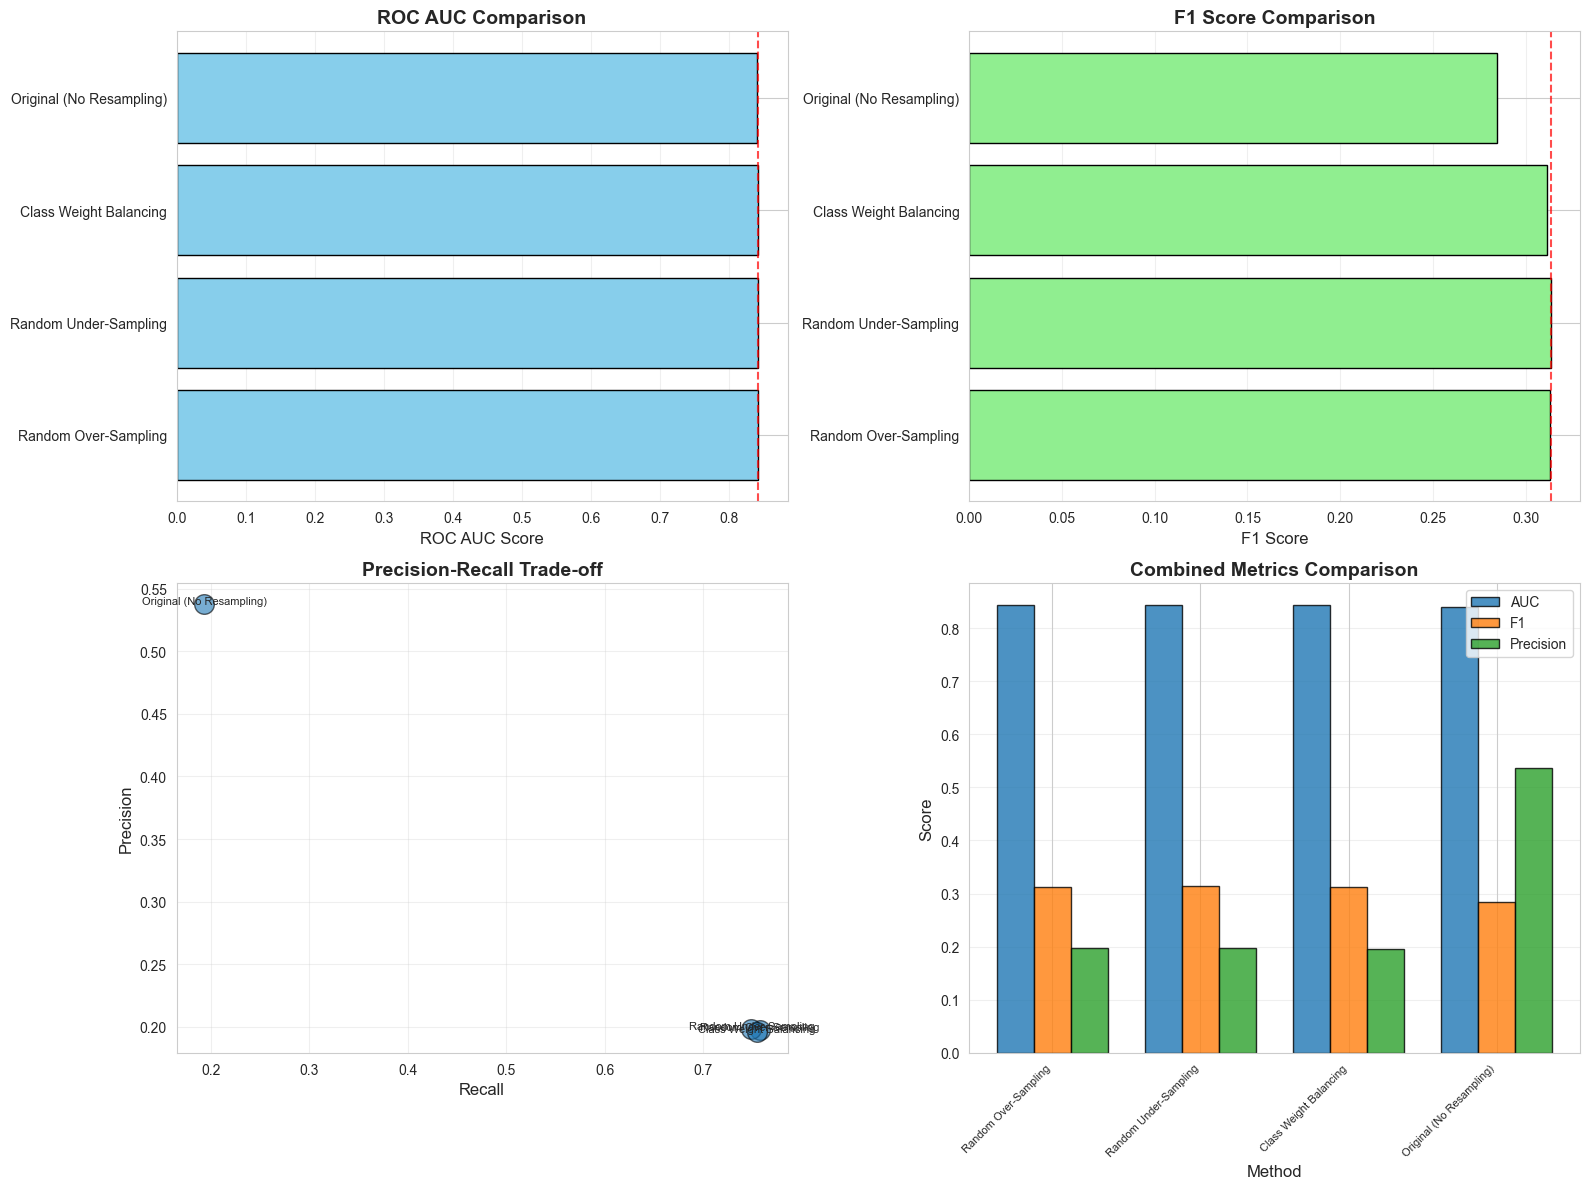


BEST METHOD SELECTION
Best method based on AUC: Random Over-Sampling
  AUC: 0.8428
  F1 Score: 0.3132
  Precision: 0.1974
  Recall: 0.7576

FINAL MODEL WITH BEST METHOD

Final Model Performance:
  AUC: 0.8428
  F1 Score: 0.3132
  Precision: 0.1974
  Recall: 0.7576

Improvement over original model:
  AUC improvement: +0.0025
  F1 improvement: +0.0286
  Precision improvement: -0.3400
  Recall improvement: +0.5641


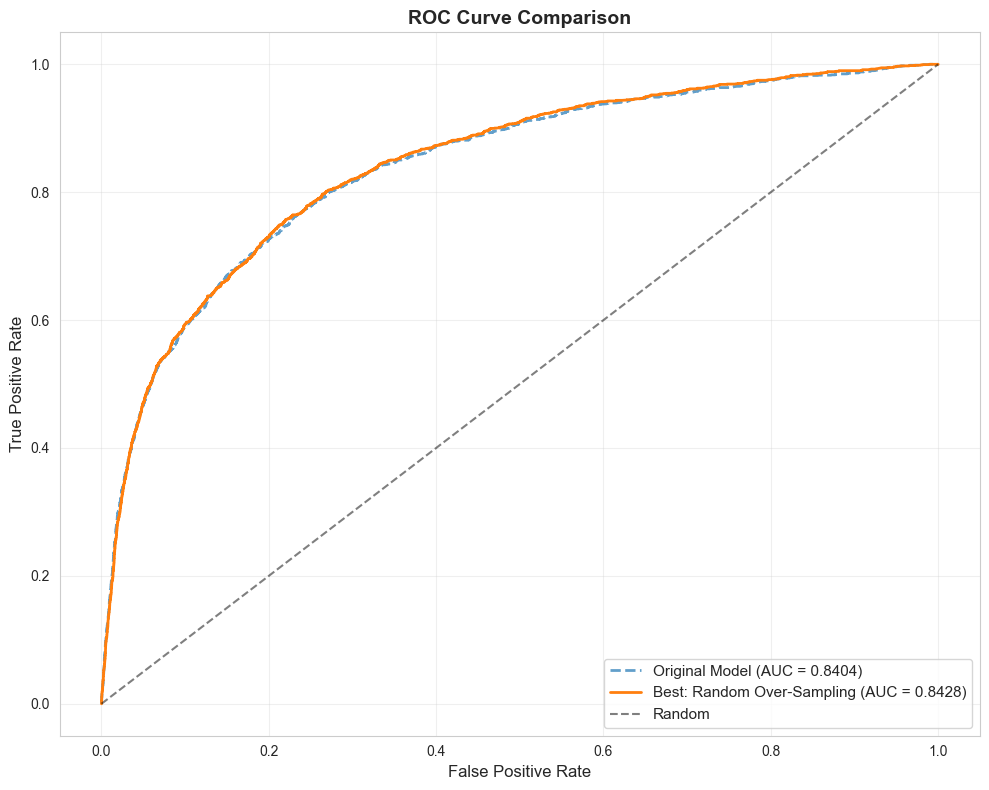

In [18]:
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

print("=" * 80)
print("CLASS IMBALANCE REDUCTION METHODS")
print("=" * 80)

# Original class distribution
print("\nOriginal class distribution:")
print(f"  Class 0 (No Default): {Counter(y_train)[0]}")
print(f"  Class 1 (Default): {Counter(y_train)[1]}")
print(f"  Imbalance Ratio: {Counter(y_train)[0] / Counter(y_train)[1]:.2f}:1")

# Prepare data for resampling
X_train_resample = X_train_final.copy()
y_train_resample = y_train.copy()
X_val_resample = X_val_final.copy()

# Method 1: Random Over-Sampling
print("\n" + "=" * 80)
print("METHOD 1: Random Over-Sampling")
print("=" * 80)
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train_resample, y_train_resample)
print(f"After resampling - Class 0: {Counter(y_ros)[0]}, Class 1: {Counter(y_ros)[1]}")

# Method 2: SMOTE (Synthetic Minority Over-sampling Technique)
print("\n" + "=" * 80)
print("METHOD 2: SMOTE")
print("=" * 80)
try:
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_smote, y_smote = smote.fit_resample(X_train_resample, y_train_resample)
    print(f"After resampling - Class 0: {Counter(y_smote)[0]}, Class 1: {Counter(y_smote)[1]}")
except Exception as e:
    print(f"SMOTE failed: {e}")
    X_smote, y_smote = X_train_resample, y_train_resample

# Method 3: ADASYN (Adaptive Synthetic Sampling)
print("\n" + "=" * 80)
print("METHOD 3: ADASYN")
print("=" * 80)
try:
    adasyn = ADASYN(random_state=42, n_neighbors=5)
    X_adasyn, y_adasyn = adasyn.fit_resample(X_train_resample, y_train_resample)
    print(f"After resampling - Class 0: {Counter(y_adasyn)[0]}, Class 1: {Counter(y_adasyn)[1]}")
except Exception as e:
    print(f"ADASYN failed: {e}")
    X_adasyn, y_adasyn = X_train_resample, y_train_resample

# Method 4: Random Under-Sampling
print("\n" + "=" * 80)
print("METHOD 4: Random Under-Sampling")
print("=" * 80)
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train_resample, y_train_resample)
print(f"After resampling - Class 0: {Counter(y_rus)[0]}, Class 1: {Counter(y_rus)[1]}")

# Method 5: SMOTE + Tomek Links (Combination)
# print("\n" + "=" * 80)
# print("METHOD 5: SMOTE + Tomek Links")
# print("=" * 80)
# try:
#     smote_tomek = SMOTETomek(random_state=42)
#     X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X_train_resample, y_train_resample)
#     print(f"After resampling - Class 0: {Counter(y_smote_tomek)[0]}, Class 1: {Counter(y_smote_tomek)[1]}")
# except Exception as e:
#     print(f"SMOTE+Tomek failed: {e}")
#     X_smote_tomek, y_smote_tomek = X_train_resample, y_train_resample

# Method 6: Class Weight Balancing (in model)
print("\n" + "=" * 80)
print("METHOD 6: Class Weight Balancing (in Logistic Regression)")
print("=" * 80)
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# Train and evaluate models with different resampling methods
print("\n" + "=" * 80)
print("TRAINING AND EVALUATING MODELS")
print("=" * 80)

methods = {
    'Original (No Resampling)': (X_train_resample, y_train_resample, False),
    'Random Over-Sampling': (X_ros, y_ros, False),
    # 'SMOTE': (X_smote, y_smote, False),
    # 'ADASYN': (X_adasyn, y_adasyn, False),
    'Random Under-Sampling': (X_rus, y_rus, False),
    # 'SMOTE + Tomek': (X_smote_tomek, y_smote_tomek, False),
    'Class Weight Balancing': (X_train_resample, y_train_resample, True)
}

results = []

for method_name, (X_method, y_method, use_class_weight) in methods.items():
    print(f"\n{method_name}:")

    # Train model
    if use_class_weight:
        lr_method = LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs',
                                       class_weight='balanced')
    else:
        lr_method = LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs')

    lr_method.fit(X_method, y_method)

    # Predictions
    y_val_pred_proba = lr_method.predict_proba(X_val_resample)[:, 1]
    y_val_pred = lr_method.predict(X_val_resample)

    # Calculate metrics
    metrics = {
        'Method': method_name,
        'AUC': roc_auc_score(y_val, y_val_pred_proba),
        'F1': f1_score(y_val, y_val_pred),
        'Precision': precision_score(y_val, y_val_pred),
        'Recall': recall_score(y_val, y_val_pred)
    }
    results.append(metrics)

    print(f"  AUC: {metrics['AUC']:.4f}, F1: {metrics['F1']:.4f}, "
          f"Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}")

# Compare results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('AUC', ascending=False)

print("\n" + "=" * 80)
print("COMPARISON OF METHODS")
print("=" * 80)
print(results_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# AUC Comparison
axes[0, 0].barh(results_df['Method'], results_df['AUC'], color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('ROC AUC Score', fontsize=12)
axes[0, 0].set_title('ROC AUC Comparison', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].axvline(x=results_df['AUC'].max(), color='red', linestyle='--', alpha=0.7)

# F1 Score Comparison
axes[0, 1].barh(results_df['Method'], results_df['F1'], color='lightgreen', edgecolor='black')
axes[0, 1].set_xlabel('F1 Score', fontsize=12)
axes[0, 1].set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')
axes[0, 1].axvline(x=results_df['F1'].max(), color='red', linestyle='--', alpha=0.7)

# Precision-Recall Comparison
axes[1, 0].scatter(results_df['Recall'], results_df['Precision'], s=200, alpha=0.6, edgecolors='black')
for idx, row in results_df.iterrows():
    axes[1, 0].annotate(row['Method'], (row['Recall'], row['Precision']),
                       fontsize=8, ha='center')
axes[1, 0].set_xlabel('Recall', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Combined Metrics
x_pos = np.arange(len(results_df))
width = 0.25
axes[1, 1].bar(x_pos - width, results_df['AUC'], width, label='AUC', alpha=0.8, edgecolor='black')
axes[1, 1].bar(x_pos, results_df['F1'], width, label='F1', alpha=0.8, edgecolor='black')
axes[1, 1].bar(x_pos + width, results_df['Precision'], width, label='Precision', alpha=0.8, edgecolor='black')
axes[1, 1].set_xlabel('Method', fontsize=12)
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].set_title('Combined Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(results_df['Method'], rotation=45, ha='right', fontsize=8)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Select best method
best_method = results_df.iloc[0]['Method']
best_auc = results_df.iloc[0]['AUC']
best_f1 = results_df.iloc[0]['F1']

print("\n" + "=" * 80)
print("BEST METHOD SELECTION")
print("=" * 80)
print(f"Best method based on AUC: {best_method}")
print(f"  AUC: {best_auc:.4f}")
print(f"  F1 Score: {best_f1:.4f}")
print(f"  Precision: {results_df.iloc[0]['Precision']:.4f}")
print(f"  Recall: {results_df.iloc[0]['Recall']:.4f}")

# Train final model with best method
print("\n" + "=" * 80)
print("FINAL MODEL WITH BEST METHOD")
print("=" * 80)

X_best, y_best, use_class_weight = methods[best_method]

if use_class_weight:
    final_model = LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs',
                                     class_weight='balanced')
else:
    final_model = LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs')

final_model.fit(X_best, y_best)

# Final predictions
y_val_final_proba = final_model.predict_proba(X_val_resample)[:, 1]
y_val_final_pred = final_model.predict(X_val_resample)

# Final metrics
final_auc = roc_auc_score(y_val, y_val_final_proba)
final_f1 = f1_score(y_val, y_val_final_pred)
final_precision = precision_score(y_val, y_val_final_pred)
final_recall = recall_score(y_val, y_val_final_pred)

print(f"\nFinal Model Performance:")
print(f"  AUC: {final_auc:.4f}")
print(f"  F1 Score: {final_f1:.4f}")
print(f"  Precision: {final_precision:.4f}")
print(f"  Recall: {final_recall:.4f}")

# Compare with original model (from cell 16)
print(f"\nImprovement over original model:")
print(f"  AUC improvement: {final_auc - val_auc:+.4f}")
print(f"  F1 improvement: {final_f1 - val_f1:+.4f}")
print(f"  Precision improvement: {final_precision - val_precision:+.4f}")
print(f"  Recall improvement: {final_recall - val_recall:+.4f}")

# ROC Curve comparison
fpr_final, tpr_final, _ = roc_curve(y_val, y_val_final_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr_val, tpr_val, label=f'Original Model (AUC = {val_auc:.4f})',
         linewidth=2, linestyle='--', alpha=0.7)
plt.plot(fpr_final, tpr_final, label=f'Best: {best_method} (AUC = {final_auc:.4f})',
         linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()